# CS4035 - Cyber Data Analytics
## Lab 4

## Group Number : 69

## Student 1 
### Name : Konrad Ponichtera
### ID : 5580749

## Student 2
### Name : Ion Babalau
### ID : 5626110

In [24]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import SGDClassifier

In [34]:
nb = nbformat.read("Lab4.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 586


## README

Expected location of dataset: _data_ directory, in same directory as notebook. 

All the necessary packages are specifeid in _requirements.txt_, and can be installed with the command: `pip install -r requirements.txt`.

## 1. Preparation (0 points)

### 1a. Load the dataset and split it into a train and test set

In [3]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [4]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,22751,22752,22753,22754,22755,22756,22757,22758,22759,22760
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30392,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30394,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Training logistic regression model before attacking

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3015
           1       0.91      0.93      0.92      3065

    accuracy                           0.92      6080
   macro avg       0.92      0.92      0.92      6080
weighted avg       0.92      0.92      0.92      6080

Accuracy: 91.90789473684211


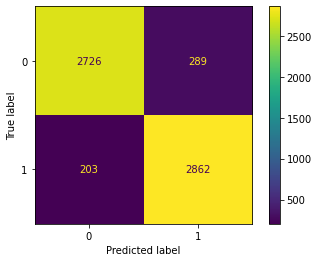

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

clf = SGDClassifier(loss='log', random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

y_predictions = clf.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [6]:
def evade(sample, coef):
    """
    Performs an evasion attack on the provided sample,
    based on the coefficient values of the linear model.
    If the coefficient value of the particular import is negative,
    it adds the import.

    Arguments:
        sample: the array-like element, representing the imports
        coef: array of the coefficient values of the linear model
    Returns:
        Copy of the passed sample with the evasion attack performed on it.
    """
    result = sample.copy()
    for i in range(len(result)):
        if coef[i] < 0:
            result[i] = 1
    return result

In [7]:
X_attack = X_test.copy()

# Coefficient values of the originally trained model and its coefficient.
# Will be used later to perform all the evasion attacks.
coef = clf.coef_[0]

# Apply the evasion attack on the malicious rows from (copy of) the test set
for i in range(len(X_attack)):
    if y_test[i] == 1:
        X_attack[i] = evade(X_attack[i], coef)


              precision    recall  f1-score   support

           0       0.47      0.90      0.62      3015
           1       0.00      0.00      0.00      3065

    accuracy                           0.45      6080
   macro avg       0.24      0.45      0.31      6080
weighted avg       0.23      0.45      0.31      6080

Accuracy: 44.83552631578947


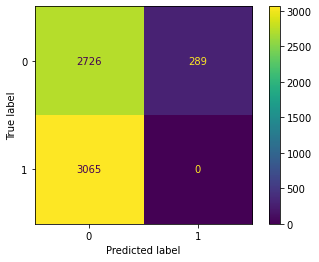

In [8]:
y_predictions = clf.predict(X_attack)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

### 2b. Analysis and answers to the questions

The implemented evasion attack adds useless import whevever the value of the linear model's coefficient is smaller than zero.
Applying it to the malicious examples from the test data manages to significantly decrease the overall accuracy of the model, leading to all the malicious examples being classified as benign.
This means that the model is not robust against adding useless imports - especially if the values of the model's coefficients are known to the attacker.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

#### Fitting the linear model

In [9]:
# Prepare the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Prepare an extra train set with malicious entries that have evasion attacks applied
X_train_attack = []
y_train_attack = []

for i in range(len(X_train)):
    if y_train[i] == 1:
        X_train_attack += [evade(X_train[i], coef)]
        y_train_attack += [1]

In [10]:
clf = SGDClassifier(loss='log', random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
clf.partial_fit(X_train_attack, y_train_attack)

SGDClassifier(loss='log', n_jobs=-1, random_state=0)

#### Test without evasion attack applied

              precision    recall  f1-score   support

           0       0.98      0.15      0.26      3015
           1       0.54      1.00      0.70      3065

    accuracy                           0.58      6080
   macro avg       0.76      0.57      0.48      6080
weighted avg       0.76      0.58      0.49      6080

Accuracy: 57.8453947368421


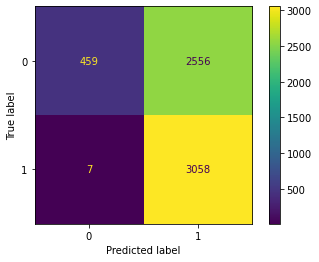

In [11]:
# Measure model performance with the original test set
y_predictions = clf.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

#### Test with evasion attack applied

In [12]:
# Measure model performance with the test set,
# where malicious samples have the evasion attack applied
X_test_attack = X_test.copy()

for i in range(len(X_test_attack)):
    if y_test[i] == 1:
        X_test_attack[i] = evade(X_test_attack[i], coef)

              precision    recall  f1-score   support

           0       1.00      0.15      0.26      3015
           1       0.55      1.00      0.71      3065

    accuracy                           0.58      6080
   macro avg       0.77      0.58      0.48      6080
weighted avg       0.77      0.58      0.49      6080

Accuracy: 57.96052631578947


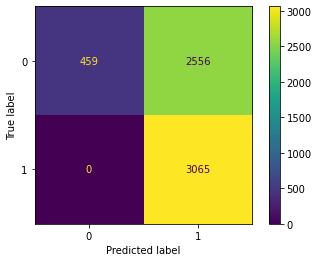

In [13]:
y_predictions = clf.predict(X_test_attack)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

### 3b. Analysis and answers to the questions

Partially fitting the model with the training samples that had the evasion attack applied to them vastly increases the recall of the malicious class and classifies the malicious samples correctly even after applying the evasion attacks to them.
However, it also significantly decreases the precision and leads to majority of the benign samples being classified as malicious.
Although one could argue that the model is good at predicting the malicious entries, in practice it cannot be reliably applied due to amount of reported false positives.

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

In [25]:
def clip_coefficients(clf):
    """
    Clips the estimator coefficients to the non-negative values.
    It modifies the original estimator and doesn't create a new one.

    Arguments:
        clf: estimator with coefficients to clip
    """
    coef_to_clip = clf.coef_[0]
    for i in range(len(coef_to_clip)):
        if coef_to_clip[i] < 0:
            coef_to_clip[i] = 0

#### Fitting classifiers with different learning batch sizes

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Partial fit batch sizes to try
batch_sizes = [5, 10, 25, 50, 100, 250, 500, 1000]
# The list of classifiers,
# trained on batch sizes from the above list
clfs = []
# The partial fit invocation counters of the classifiers,
# trained on batch sizes from the above list
partial_fit_counters = []
partial_fit_time = []

for batch_size in batch_sizes:
    print('Training for batch size: ', batch_size)
    clf = SGDClassifier(loss='log', random_state=0, n_jobs=-1)
    partial_fit_counter = 0
    start_time = time.time()
    for i in range(0, len(X_train), batch_size):
        partial_fit_counter += 1
        clf.partial_fit(X_train[i:i+batch_size], y_train[i:i+batch_size], classes=[0, 1])
        # Clip the coefficients to non-negative values after every training batch
        clip_coefficients(clf)
    end_time = time.time() - start_time
    clfs += [clf]
    partial_fit_counters += [partial_fit_counter]
    partial_fit_time += [end_time]
    print(f'Training for batch size {batch_size} took {end_time} seconds')

Training for batch size:  5
Training for batch size 5 took 37.7323362827301 seconds
Training for batch size:  10
Training for batch size 10 took 23.966496467590332 seconds
Training for batch size:  25
Training for batch size 25 took 13.027670621871948 seconds
Training for batch size:  50
Training for batch size 50 took 7.5735414028167725 seconds
Training for batch size:  100
Training for batch size 100 took 5.447402715682983 seconds
Training for batch size:  250
Training for batch size 250 took 4.388100624084473 seconds
Training for batch size:  500
Training for batch size 500 took 3.924659013748169 seconds
Training for batch size:  1000
Training for batch size 1000 took 3.400862216949463 seconds


In [27]:
# Prepare test dataset with the evasion attacks applied to the malicious samples
X_test_attack = X_test.copy()

for i in range(len(X_test_attack)):
    if y_test[i] == 1:
        X_test_attack[i] = evade(X_test_attack[i], coef)

***** BATCH SIZE 5 (partial fit calls: 4864) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3015
           1       0.88      0.80      0.84      3065

    accuracy                           0.84      6080
   macro avg       0.85      0.84      0.84      6080
weighted avg       0.85      0.84      0.84      6080

Accuracy: 84.32565789473684
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3015
           1       0.90      1.00      0.95      3065

    accuracy                           0.94      6080
   macro avg       0.95      0.94      0.94      6080
weighted avg       0.95      0.94      0.94      6080

Accuracy: 94.24342105263158


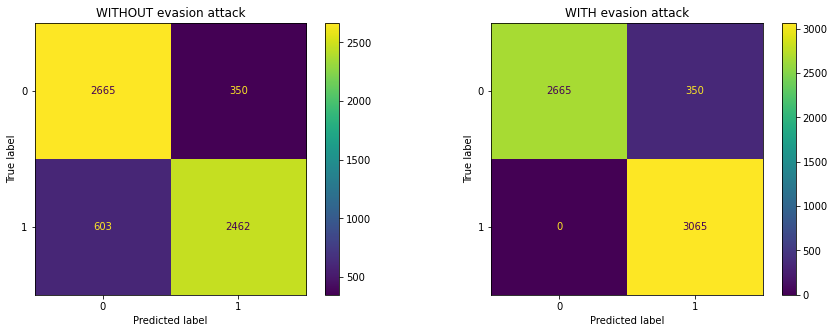

***** BATCH SIZE 10 (partial fit calls: 2432) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.76      0.39      0.51      3015
           1       0.59      0.88      0.71      3065

    accuracy                           0.64      6080
   macro avg       0.68      0.63      0.61      6080
weighted avg       0.68      0.64      0.61      6080

Accuracy: 63.63486842105262
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      3015
           1       0.62      1.00      0.77      3065

    accuracy                           0.70      6080
   macro avg       0.81      0.69      0.66      6080
weighted avg       0.81      0.70      0.66      6080

Accuracy: 69.50657894736842


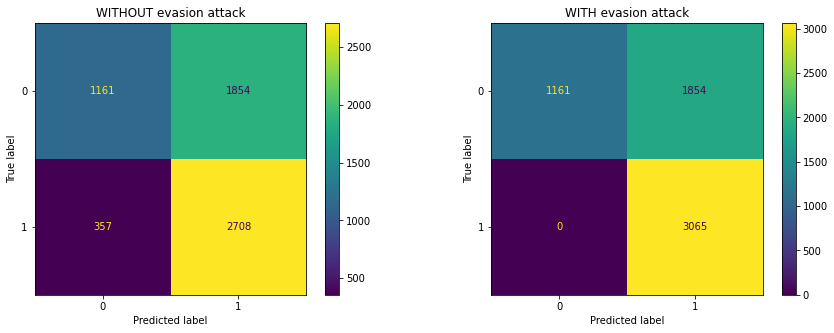

***** BATCH SIZE 25 (partial fit calls: 973) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.84      0.48      0.61      3015
           1       0.64      0.91      0.75      3065

    accuracy                           0.70      6080
   macro avg       0.74      0.70      0.68      6080
weighted avg       0.74      0.70      0.68      6080

Accuracy: 69.73684210526315
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65      3015
           1       0.66      1.00      0.80      3065

    accuracy                           0.74      6080
   macro avg       0.83      0.74      0.73      6080
weighted avg       0.83      0.74      0.73      6080

Accuracy: 74.45723684210527


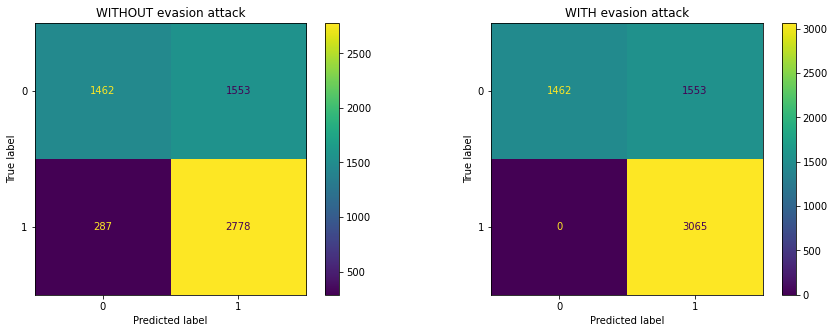

***** BATCH SIZE 50 (partial fit calls: 487) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      3015
           1       0.75      0.90      0.82      3065

    accuracy                           0.80      6080
   macro avg       0.81      0.80      0.79      6080
weighted avg       0.81      0.80      0.79      6080

Accuracy: 79.65460526315789
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      3015
           1       0.77      1.00      0.87      3065

    accuracy                           0.85      6080
   macro avg       0.88      0.84      0.84      6080
weighted avg       0.88      0.85      0.84      6080

Accuracy: 84.60526315789474


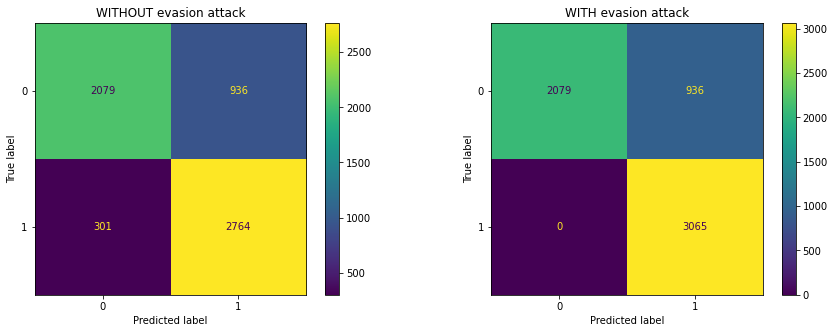

***** BATCH SIZE 100 (partial fit calls: 244) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.67      0.07      0.13      3015
           1       0.51      0.97      0.67      3065

    accuracy                           0.52      6080
   macro avg       0.59      0.52      0.40      6080
weighted avg       0.59      0.52      0.40      6080

Accuracy: 52.203947368421055
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.07      0.13      3015
           1       0.52      1.00      0.69      3065

    accuracy                           0.54      6080
   macro avg       0.76      0.54      0.41      6080
weighted avg       0.76      0.54      0.41      6080

Accuracy: 53.89802631578947


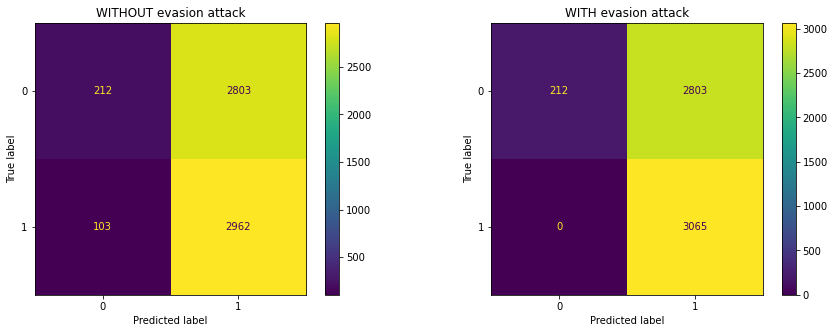

***** BATCH SIZE 250 (partial fit calls: 98) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.64      0.06      0.11      3015
           1       0.51      0.97      0.67      3065

    accuracy                           0.52      6080
   macro avg       0.57      0.51      0.39      6080
weighted avg       0.57      0.52      0.39      6080

Accuracy: 51.661184210526315
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.06      0.11      3015
           1       0.52      1.00      0.68      3065

    accuracy                           0.53      6080
   macro avg       0.76      0.53      0.40      6080
weighted avg       0.76      0.53      0.40      6080

Accuracy: 53.338815789473685


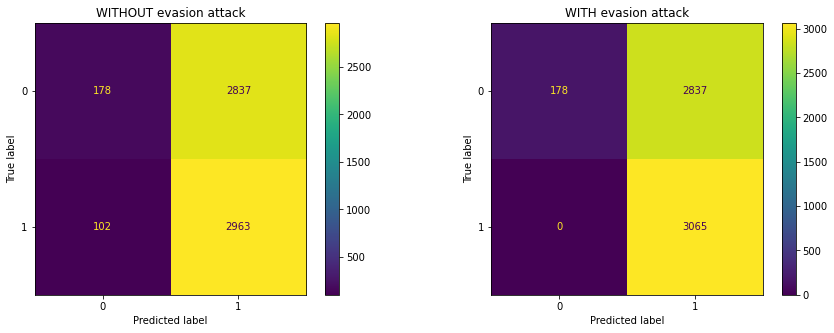

***** BATCH SIZE 500 (partial fit calls: 49) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.55      0.03      0.07      3015
           1       0.51      0.97      0.67      3065

    accuracy                           0.51      6080
   macro avg       0.53      0.50      0.37      6080
weighted avg       0.53      0.51      0.37      6080

Accuracy: 50.70723684210526
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.03      0.07      3015
           1       0.51      1.00      0.68      3065

    accuracy                           0.52      6080
   macro avg       0.76      0.52      0.37      6080
weighted avg       0.75      0.52      0.38      6080

Accuracy: 52.13815789473685


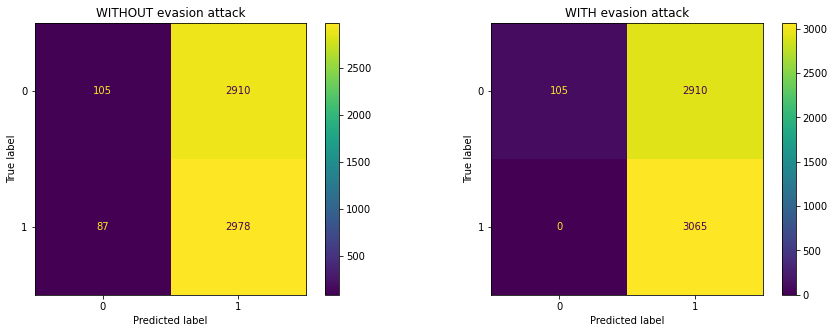

***** BATCH SIZE 1000 (partial fit calls: 25) *****
Classification report for samples WITHOUT evasion attack:
              precision    recall  f1-score   support

           0       0.56      0.03      0.05      3015
           1       0.51      0.98      0.67      3065

    accuracy                           0.51      6080
   macro avg       0.53      0.50      0.36      6080
weighted avg       0.53      0.51      0.36      6080

Accuracy: 50.690789473684205
Classification report for samples WITH evasion attack:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05      3015
           1       0.51      1.00      0.68      3065

    accuracy                           0.52      6080
   macro avg       0.76      0.51      0.36      6080
weighted avg       0.75      0.52      0.37      6080

Accuracy: 51.67763157894737


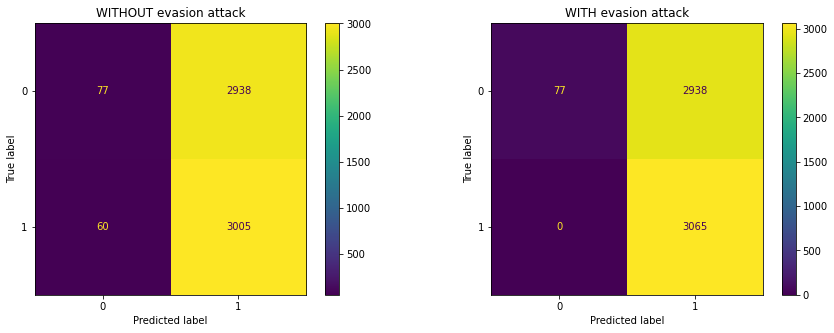

In [28]:
# Accuracies of the classifiers when measured on the samples
# without evasion attack applied to the malicious ones
clf_accuracies = []
# Accuracies of the classifiers when measured on the samples
# WITH evasion attack applied to the malicious ones
clf_evasion_accuracies = []

for i, batch_size in enumerate(batch_sizes):
    print(f'***** BATCH SIZE {batch_size} (partial fit calls: {partial_fit_counters[i]}) *****')

    y_predictions = clfs[i].predict(X_test)
    y_evasion_predictions = clfs[i].predict(X_test_attack)

    accuracy = accuracy_score(y_test, y_predictions) * 100
    evasion_accuracy = accuracy_score(y_test, y_evasion_predictions) * 100
    clf_accuracies += [accuracy]
    clf_evasion_accuracies += [evasion_accuracy]

    print('Classification report for samples WITHOUT evasion attack:')
    print(classification_report(y_test, y_predictions))
    print("Accuracy:", accuracy)
    print('Classification report for samples WITH evasion attack:')
    print(classification_report(y_test, y_evasion_predictions))
    print("Accuracy:", evasion_accuracy)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_predictions, ax=ax1)
    ax1.set_title('WITHOUT evasion attack')
    ConfusionMatrixDisplay.from_predictions(y_test, y_evasion_predictions, ax=ax2)
    ax2.set_title('WITH evasion attack')
    plt.show()

In [29]:
accuracies = {
    'Accuracy without evasion': clf_accuracies,
    'Accuracy with evasion': clf_evasion_accuracies
}

df_iterations = pd.DataFrame(accuracies, index=batch_sizes)
df_iterations

,Accuracy without evasion,Accuracy with evasion
5,84.325658,94.243421
10,63.634868,69.506579
25,69.736842,74.457237
50,79.654605,84.605263
100,52.203947,53.898026
250,51.661184,53.338816
500,50.707237,52.138158
1000,50.690789,51.677632


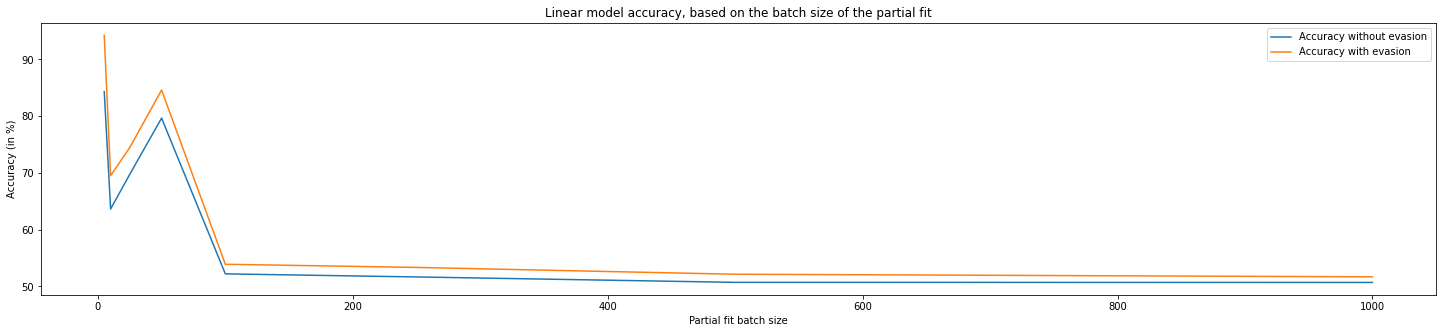

In [30]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))
df_iterations.plot(
    ax=ax,
    title='Linear model accuracy, based on the batch size of the partial fit',
    xlabel='Partial fit batch size',
    ylabel='Accuracy (in %)',
)
plt.show()

In [31]:
df_time = pd.DataFrame({'Time': partial_fit_time}, index=batch_sizes)
df_time

,Time
5,37.732336
10,23.966496
25,13.027671
50,7.573541
100,5.447403
250,4.388101
500,3.924659
1000,3.400862


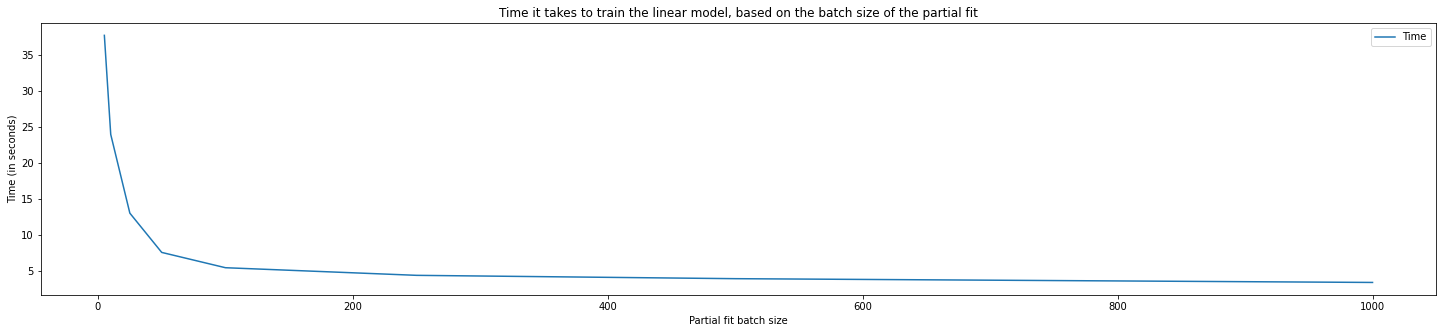

In [33]:
_, ax = plt.subplots(1, 1, figsize=(25, 5))
df_time.plot(
    ax=ax,
    title='Time it takes to train the linear model, based on the batch size of the partial fit',
    xlabel='Partial fit batch size',
    ylabel='Time (in seconds)',
)
plt.show()

### 4b. Analysis and answers to the questions.

The coefficient clipping seems to achieve better results than hardening the model.
Although both methods reach high recall when it comes to classifying malicious samples - both with and without evasion attacks applied - the false positive count (benign entries classified as malicious) for clipping is much lower than for hardening.
This is true especially for the smaller batches of partial fit, where after each batch the coefficients are limited to non-negative values.

We can observe that the model's accuracy decreases as the partial fit batch size increases.
The larger the partial fit batch size is, the less precise the model becomes, leaning towards classifying all the entries as malicious.
This stems from the fact that the clipping is performed less often, losing more information in the process.
Larger batch sizes lead to less false negatives (malicious entries classified as benign) for malicious entries with both evasion attack applied and not. 
However, it also quickly decreases the recall for benign class and leads to more false positives.

From the practical perspective it is much more beneficial to use the coefficient clipping method.
The smaller batch sizes are able to train the model, which is robust against the evasion attacks and has a reasonable recall for both benign and malicious classes (does not trigger too many false positives).
However, the smaller batches take much more time to train than the larger ones.
From the plot above we can see a significant jump in accuracy for the batches of 50 samples, while keeping the training time over 5 times shorter than for the training batches of size 5.
This means that it could be the sweet spot for the systems, where the continuous training is utilized.